In [1]:
%matplotlib inline

d_noise =  10


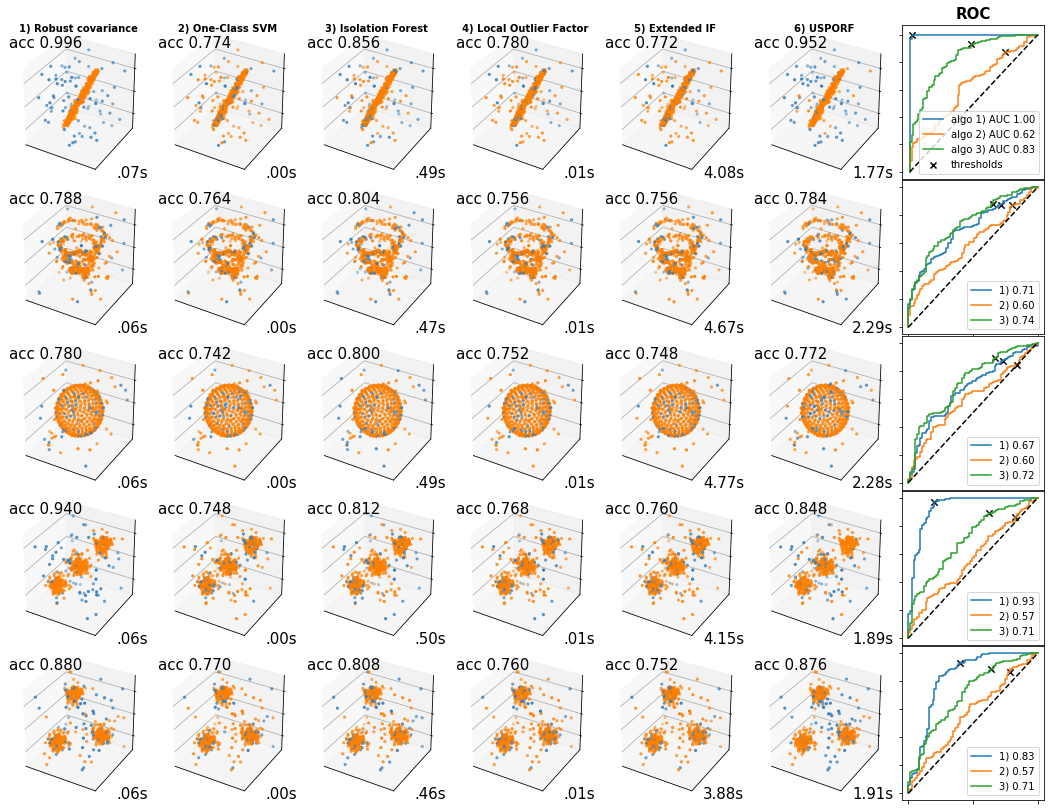

In [3]:
"""
============================================================================
Comparing anomaly detection algorithms for outlier detection on 3D toy 
datasets
============================================================================

This example shows characteristics and compares the performance of different 
anomaly detection algorithms on 3D datasets. Datasets contain one or three 
modes (region of high density) to illustrate the ability of algorithm to 
cope with multimodel data.

Algorithms:
- Robust covariance, `sklearn.covariance.EllipticEnvelope`
- One-Class SVM, `sklearn.svm.OneClassSVM`
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- Local Outlier Factor (LOF), `sklearn.neighbors.LocalOutlierFactor`
- Extended Isolation Forest (EIF), `iso`
- Unsupervised Sparse Projection Oblique Randomer Forest(SPORF), 
`UnsupervisedRandomForest`

Here are the update in this example:
- Change the datasets from two to three informative dimensions
- Take dimensional noise into account
- Add EIF and USPORF algorithms
- Add the quatitative parameters to compare the algorithms performance
    - `accuracy_score`: to measure the anomaly detection ability
    - `roc_curve`: to visualize the operating characteristic (ROC) curve 
    (tpr vs. fpr)
    - `roc_auc_score`: to calculate the area under ROC curve
    
Note:
Only the algorithm that has `decision_function` can compute `roc_curve`
and `roc_auc_score`. Thus, we still lack important parameters to compare the 
LOF, EIF, and USPORF against other algorithms.

How to predict outliers in EIF and USPORF:
Since EIF and SPORF are not in sklearn, they don't have `fit.predict` 
function. I sort the `compute_paths` 
- For EIF, I sort the average root length score (`compute_paths`). 
The longest average path data will be outliers
- For USPORF, I sort the row sum similar matrix (`sim_mat.sum`). 
And the highest score data will be inliers

Result and disscussion:
The figures show the outlier detection performance and visualization. 
Each row represents different datasets. The first four columns compare each
algorithm the computation time (``.__ s``) and outlier prediction accuracy 
(``acc``). The number and name of each outlier detection algorithm are on 
the top of the column. The last column plots all four algorithms in 
the ROC curve compare AUC score. The number label on AUC score matches the 
number in front of the algorithm names. The ``x`` sign in the ROC curves 
indicate the thresholds where algorithms start to classify data as outliers.

From the plots, ``sklearn.covariance.EllipticEnvelope`` shows best result 
in high dimensional noise ``d_noise = 10``. However, since robust 
covariance creates a ellptical envelope for inliers, we need more test 
on an inlier data that is not in a elliptical shape.

Possible Improvement:
Find the way to calculate `decision_function` from EIF and USPORF

"""

%matplotlib inline

#-------------------------------------------------------------------
# Graphing and calculation packages
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import time
from sklearn.datasets import make_moons, make_blobs

# Algorithm packages
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import eif as iso
from rerf.urerf import UnsupervisedRandomForest

# Performance measurement packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#-------------------------------------------------------------------
# Data parameter
d_noise = 10  # number of Gaussian dimensional noise
n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
line_sd = 0.06  # sd of the line in dataset 1 and 2
cluster_sd = 0.2  # sd of the cluster in dataset 4 and 5
noise_sd = 2  # sd of the cluster in dimensional noise

# Define datasets
## 1: Linear
def fun_linear(samples=1, sd=0.0):
    t_lin = np.transpose(np.linspace(-1, 1, samples))
    X_lin = np.c_[
        0.4 * t_lin + sd * np.random.randn(samples),
        0.6 * t_lin + sd * np.random.randn(samples),
        t_lin + sd * np.random.randn(samples),
    ]
    return X_lin


X_lin = fun_linear(samples=n_inliers, sd=line_sd)

## 2: Helix
def fun_helix(samples=1, sd=0.0):
    t_hex = np.transpose(np.linspace(2 * np.pi, 9 * np.pi, samples))
    xline = t_hex * np.cos(t_hex)  # before rescale
    xline = xline / (max(xline) - min(xline)) * 2 + sd * np.random.randn(samples)
    yline = t_hex * np.sin(t_hex)  # before rescale
    yline = yline / (max(yline) - min(yline)) * 2 + sd * np.random.randn(samples)
    zline = (t_hex - (max(t_hex) + min(t_hex)) / 2) / (
        max(t_hex) - min(t_hex)
    ) * 2 + sd * np.random.randn(samples)
    X_hex = np.c_[xline, yline, zline]
    return X_hex


X_hex = fun_helix(samples=n_inliers, sd=line_sd)

## 3: Sphere, equally distribution
def fibonacci_sphere(samples=1, randomize=True):
    rnd = 1.0
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2.0 / samples
    increment = np.pi * (3.0 - np.sqrt(5.0))
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x, y, z])
    return points


X_sph = np.array(fibonacci_sphere(samples=n_inliers))

## 4: Gaussian Mixture
def gaussian_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_gau = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0, 0, 0], [0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_gau


X_gau = gaussian_blobs(samples=n_inliers, sd=cluster_sd)

## 5: Misaligned Gaussian Mixture
def misaligned_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_misaligned = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0.7, 0.7, -0.7], [-0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_misaligned


X_misaligned = misaligned_blobs(samples=n_inliers, sd=cluster_sd)

## 6: Whole dataset
datasets3D = [X_lin, X_hex, X_sph, X_gau, X_misaligned]

# define to data label: y_true
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)
# label 1 as inliers, -1 as outliers


# Define algorithm to be compared -------------------------------
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    (
        "One-Class SVM",
        svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma="scale"),
    ),
    (
        "Isolation Forest",
        IsolationForest(
            n_estimators=500,
            behaviour="new",
            contamination=outliers_fraction,
            random_state=42,
        ),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(
            n_neighbors=35, contamination=outliers_fraction, novelty=False
        ),
    ),
    (
        "Extended IF",
        iso.iForest(datasets3D[0], ntrees=500, sample_size=255, ExtensionLevel=1),
    ),
    (
        "USPORF",
        UnsupervisedRandomForest(
            feature_combinations="auto",
            max_depth=None,
            max_features="auto",
            min_samples_split="auto",
            n_estimators=500,
            n_jobs=None,
            projection_matrix="RerF",
        ),
    ),
]


# Plot -----------------------------
plt.figure(figsize=((len(anomaly_algorithms) + 1) * 2 + 1, len(datasets3D) * 2 + 1))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.98, wspace=0.05, hspace=0.01
)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset3D, X in enumerate(datasets3D):
    # add uniform distribution outliers
    X = np.concatenate(
        [X, rng.uniform(low=-1.5, high=1.5, size=(n_outliers, 3))], axis=0
    )
    # add Gaussian dimensional noise, set the center at origin
    X_noise = make_blobs(
        n_samples=n_samples,
        centers=1,
        n_features=d_noise,
        random_state=0,
        cluster_std=1,
        center_box=(0.0, 0.0),
    )[0]
    X = np.append(X, X_noise, axis=1)

    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []

    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()

        if name == "Extended IF":  # Extended IF doesn't has fit function
            algorithm = iso.iForest(
                X, ntrees=500, sample_size=min(256, len(X)), ExtensionLevel=d_noise + 2
            )
        else:
            algorithm.fit(X)
        t1 = time.time()

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)

        elif name == "Extended IF":  # Extended IF doesn't have predict function
            Score = algorithm.compute_paths(X_in=X)  # compute anomaly score
            sE = np.argsort(Score)
            indicesE = sE[
                -int(np.ceil(outliers_fraction * X.shape[0])) :
            ]  # outlier indices
            y_pred = np.ones(X.shape[0])
            y_pred[indicesE] = -1
            y_pred = y_pred.astype(int)  # convert float to int array

        elif name == "USPORF":  # USPORF doesn't have predict function
            sim_mat = algorithm.transform()  # create similarity matrix
            sim_sum = sim_mat.sum(axis=1)
            sU = np.argsort(sim_sum)
            indicesU = sU[
                : int(np.floor(outliers_fraction * X.shape[0]))
            ]  # outlier indeces
            y_pred = np.ones(X.shape[0])
            y_pred[indicesU] = -1
            y_pred = y_pred.astype(int)  # convert float to int array

        else:
            y_pred = algorithm.fit(X).predict(X)
            probas_ = algorithm.fit(X).decision_function(X)
            ## LOF doesn't have decision_function
            AUC = roc_auc_score(y_true, probas_)
            fpr, tpr, thresholds = roc_curve(y_true, probas_)
            thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]
            # store ROC curve
            list_AUC.append(AUC)
            list_fpr.append(fpr)
            list_tpr.append(tpr)
            list_thresh.append(thresh_index)

        # compute the accuracy
        acc = accuracy_score(y_true, y_pred)

        # add data plot
        ax = plt.subplot(
            len(datasets3D), len(anomaly_algorithms) + 1, plot_num, projection="3d"
        )
        ax.axis("on")
        if i_dataset3D == 0:
            plt.title(
                str(algo_index + 1) + ") " + name, size=10, color="black", weight="bold"
            )  # use function's name for a title
        colors = np.array(["#377eb8", "#ff7f00"])
        # color plot ('blue' = outlier, 'orange'=inlier)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=5, color=colors[((y_pred + 1) // 2)])
        ax.text2D(
            0.01,
            0.85,
            ("acc %.3f" % acc).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="left",
        )
        ax.text2D(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.zaxis.set_ticklabels([])
        algo_index += 1
        plot_num += 1

    # add ROC plot
    ax = plt.subplot(len(datasets3D), len(anomaly_algorithms) + 1, plot_num)

    if i_dataset3D == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        # lebel the decision_function's thresholds
        plt.scatter([], [], marker="x", color="black", label="thresholds")

    for algo_index in range(len(anomaly_algorithms) - 3):
        ## exclude LOF, EIF, and USPORF

        if i_dataset3D == 0:
            ax.plot(
                list_fpr[algo_index],
                list_tpr[algo_index],
                label="algo "
                + str(algo_index + 1)
                + ")"
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"),
            )
        else:
            ax.plot(
                list_fpr[algo_index],
                list_tpr[algo_index],
                label=str(algo_index + 1)
                + ")"
                + (" %.2f" % list_AUC[algo_index]).lstrip("0"),
            )
        ax.scatter(
            list_fpr[algo_index][list_thresh[algo_index]],
            list_tpr[algo_index][list_thresh[algo_index]],
            s=40,
            edgecolor="yellow",
            marker="x",
            color="black",
        )
    ax.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    # show the legend
    ax.legend()
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plot_num += 1
print("d_noise = ", str(d_noise))
plt.show()